In [ ]:
!nvidia-smi

Sun May 25 06:00:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_dir = '/content/drive/MyDrive/deeplearning asm2/'

In [ ]:
import os
import json
import zipfile

# kaggle api
kaggle_json_str = """
{

}
"""

#  write kaggle.json
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
    f.write(kaggle_json_str.strip())
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

# download
os.makedirs('./data', exist_ok=True)
os.system('kaggle competitions download -c multi-label-classification-competition-2025 -p ./data')

# unzip
for file in os.listdir('./data'):
    if file.endswith('.zip'):
        with zipfile.ZipFile(f'./data/{file}', 'r') as zip_ref:
            zip_ref.extractall('./data')


In [ ]:
!pip install torchinfo

In [ ]:
import re
import pandas as pd
import numpy as np
from io import StringIO
import os
import torch
import torchvision.transforms as T
import torch.nn.functional as F
from PIL import Image
from transformers import BertTokenizer, AutoTokenizer
import os
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from torchinfo import summary
sns.set(style="whitegrid")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

FILENAME = 'train.csv'

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

DIR = '/content/data/COMP5329S1A2Dataset/'
FILENAME = 'train.csv'

In [ ]:
NUM_CLASSES = 19

### Data Preparation

change label to matrix

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

with open(DIR + FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
#convert Caption to lowwer case
df['Caption'] = df['Caption'].str.lower()

labels = df['Labels'].apply(lambda x: [int(i)-1 for i in x.split()])
mlb = MultiLabelBinarizer()
mlb.fit(labels)
labels = mlb.transform(labels)


In [ ]:
label_counts = np.sum(labels, axis=0)
original_labels = [i for i in range(1, 20) if i != 11]


tokenizer

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-mini")

MAX_LEN = 32

# Function to encode captions using the tokenizer and add them to the DataFrame
def encode_captions_to_df(df, tokenizer, max_len=32):
    encodings = tokenizer(
        df["Caption"].tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )
    df["input_ids"] = list(encodings["input_ids"].numpy())
    df["attention_mask"] = list(encodings["attention_mask"].numpy())
    return df

df = encode_captions_to_df(df, tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

## upsampling

In [ ]:
from sklearn.model_selection import train_test_split

# split the DataFrame into training and validation sets
train_df, val_df, train_labels, val_labels = train_test_split(
    df, labels, test_size=0.2, random_state=42, stratify=labels.sum(axis=1)
)

# print the shape of the training and validation sets
print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
# print the number of samples for each label in the training set
label_counts = train_labels.sum(axis=0)
print("Num of each label:", label_counts)


Training set shape: (23996, 5)
Validation set shape: (6000, 5)
Num of each label: [18233   918  3499  1004   911  1108   976  1747   841  1190   508   516
   203  1527   862  1130  1230   821]


In [ ]:
#  Find all sample indices for label=0 (original class 1)
class_0_indices = np.where(train_labels[:, 0] == 1)[0]

# Randomly downsample class 0 to 18233 samples (no downsampling)
np.random.seed(42)
reduced_class_0_indices = np.random.choice(class_0_indices, size=18233, replace=False)

# For other classes, oversample to 800 samples each (except class 1)
target_per_class = 800
augmented_indices = []

for class_idx in range(train_labels.shape[1]):
    if class_idx == 0:
        continue  # Skip class 1

    sample_indices = np.where(train_labels[:, class_idx] == 1)[0]
    current_count = len(sample_indices)
    if current_count < target_per_class:
        needed = target_per_class - current_count
        repeats = np.random.choice(sample_indices, size=needed, replace=True)
        augmented_indices.extend(repeats.tolist())

# Other normal samples that are not class_0
other_indices = [i for i in range(len(train_labels)) if i not in class_0_indices]

# Total indices = downsampled class 0 + normal other classes + oversampled augmented samples
final_indices = list(reduced_class_0_indices) + other_indices + augmented_indices

# Shuffle the order
np.random.shuffle(final_indices)

# Get the final df and labels
train_df_balanced = train_df.iloc[final_indices].reset_index(drop=True)
train_labels_balanced = train_labels[final_indices]

# statistics of the balanced dataset
labelaug_counts = train_labels_balanced.sum(axis=0)
print("Num of oversampled labels: ", labelaug_counts)


Num of oversampled labels:  [18725  1012  4130  1043   914  1166   988  1929   846  1346   855   841
   810  1561   878  1139  1242   830]


## Pytorch Dataset


In [ ]:
from torch.utils.data import Dataset, random_split, DataLoader
from torch.utils.data import Dataset
from PIL import Image
import torch
import os
import numpy as np
class ImgCapData(Dataset):
    def __init__(self, df, label_matrix, image_dir='data', transform=None):
        self.df = df.reset_index(drop=True)
        self.labels = torch.FloatTensor(label_matrix)
        self.image_dir = image_dir
        self.transform = transform

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        image_path = os.path.join(self.image_dir, row["ImageID"])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        input_ids = torch.tensor(row["input_ids"])
        attention_mask = torch.tensor(row["attention_mask"])
        label = self.labels[idx]

        return {
            "image": image,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": label,
            "caption": row["Caption"]
        }

    def __len__(self):
        return len(self.df)

## Data augmentation for training


In [ ]:
# train transform definition
train_transform = T.Compose([
    T.RandomRotation(degrees=(-20, 20)), # Random rotation between -20 and 20 degrees
    T.RandomResizedCrop(384, scale=(0.7, 1.0), ratio=(3. / 4., 4. / 3.)), # Randomly crop to 384x384 with aspect ratio between 3:4 and 4:3
    T.RandomHorizontalFlip(0.5), # Random horizontal flip with 50% probability
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet mean and std
])

# validation transform definition
val_transform = T.Compose([
    T.Resize(400),                 # Resize shorter side to 400
    T.CenterCrop(384),          # Center crop to 384×384
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet mean and std
])


In [ ]:
from torch.utils.data import Dataset, random_split, DataLoader

# Create datasets
train_dataset = ImgCapData(train_df_balanced, train_labels_balanced , image_dir=DIR + 'data', transform=train_transform)
val_dataset = ImgCapData(val_df, val_labels, image_dir=DIR+'data', transform=val_transform)


In [ ]:
batch_size = 32

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=4
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    # num_workers=4
)


## show samples

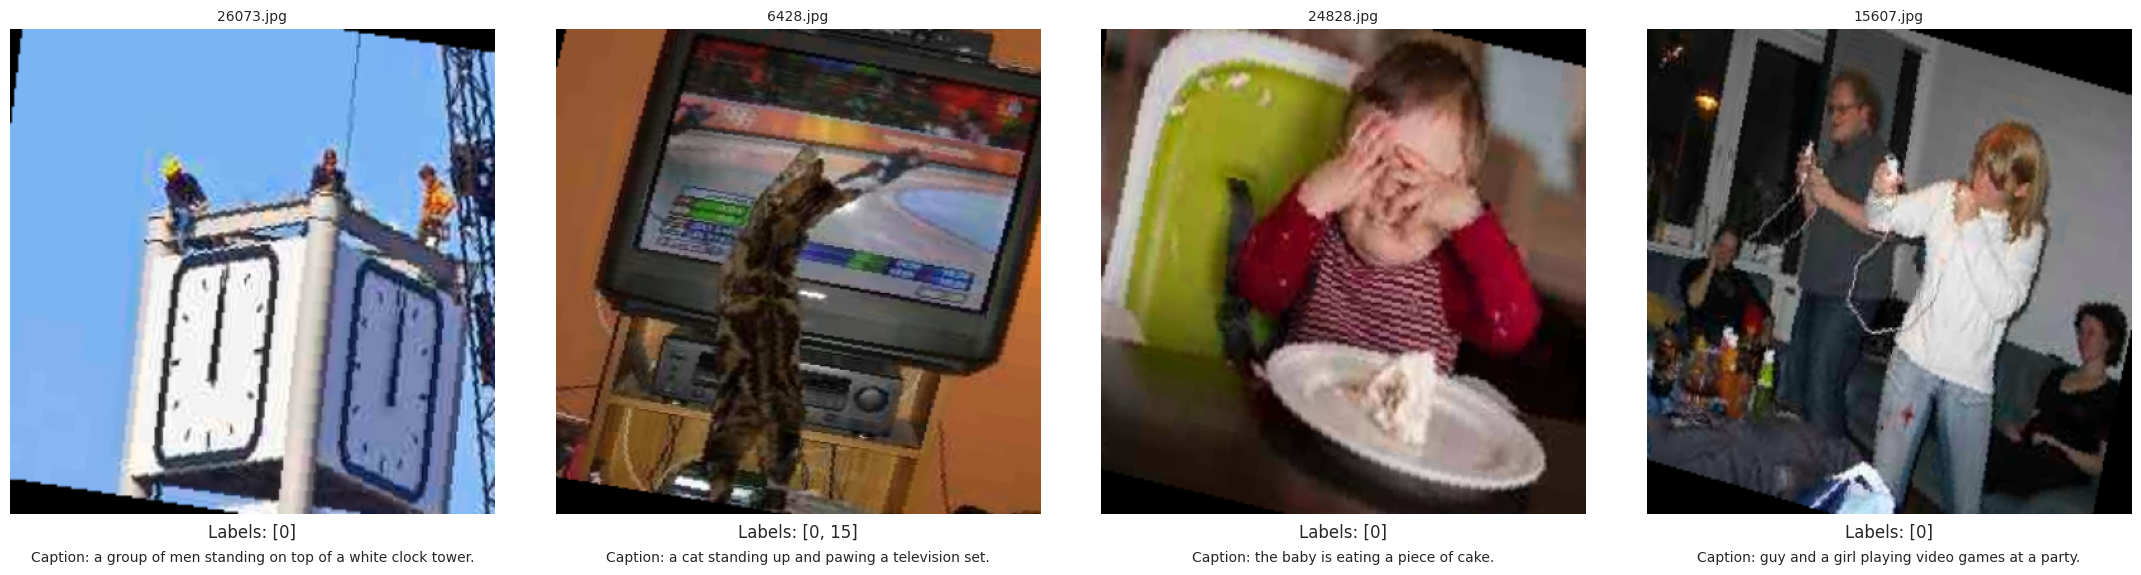

In [ ]:
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

import matplotlib.pyplot as plt
import random

# randomly select 4 samples from the training dataset
indices = random.sample(range(len(train_dataset)), 4)
samples = [train_dataset[i] for i in indices]

fig, axs = plt.subplots(1, 4, figsize=(22, 6))

for i, (sample, ax) in enumerate(zip(samples, axs)):
    image = sample["image"]
    caption = sample["caption"]
    labels = sample["label"].numpy()
    image_id = train_dataset.df.loc[indices[i], "ImageID"]
    image = unnormalize(image)
    # from tensor to numpy array
    if isinstance(image, torch.Tensor):
        image_np = image.permute(1, 2, 0).numpy()
        image_np = np.clip(image_np, 0, 1)
    else:
        image_np = np.array(image)

    ax.imshow(image_np)
    ax.axis("off")

    # set the title to the image ID
    ax.set_title(image_id, fontsize=10)

    # add labels and caption text below the image
    ax.text(0.5, -0.05, f"Labels: {np.where(labels==1)[0].tolist()}",
            transform=ax.transAxes, fontsize=12, ha='center', wrap=True)
    ax.text(0.5, -0.1, f"Caption: {caption}",
            transform=ax.transAxes, fontsize=10, ha='center', wrap=True)

plt.tight_layout()
plt.show()


In [ ]:
batch = next(iter(train_loader))

print("Image batch shape:", batch["image"].shape)          # [B, 3, H, W]
print("Input IDs shape:", batch["input_ids"].shape)        # [B, max_len]
print("Attention mask shape:", batch["attention_mask"].shape)
print("Label shape:", batch["label"].shape)                # [B, 18] (19 classes, but class 11 is removed)


Image batch shape: torch.Size([32, 3, 384, 384])
Input IDs shape: torch.Size([32, 32])
Attention mask shape: torch.Size([32, 32])
Label shape: torch.Size([32, 18])


## Modules

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from torchvision import models

attention pooling, image encoder, text encoder, fusion transformer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class AttentionPool2d(nn.Module):
    """
    ref: https://github.com/mlfoundations/open_clip/blob/main/src/open_clip/modified_resnet.py
    """
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim**2 + 1, embed_dim) / embed_dim ** 0.5)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        # x: [B, C, H, W] → [HW, B, C]
        x = x.reshape(x.shape[0], x.shape[1], -1).permute(2, 0, 1)
        cls_token = x.mean(dim=0, keepdim=True)  # [1, B, C]
        x = torch.cat([cls_token, x], dim=0)  # [HW+1, B, C]
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # add position emb

        x, _ = F.multi_head_attention_forward(
            query=x, key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None, bias_v=None, add_zero_attn=False, dropout_p=0.0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )
        return x.permute(1, 0, 2)  # → [B, HW+1, D]




class ResNet50Encoder(nn.Module):
    def __init__(self, out_dim=384, num_heads=4, feature_map_size=12):
        super().__init__()
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # remove fc and avgpool
        self.features = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool,
            backbone.layer1,
            backbone.layer2,
            backbone.layer3,
            backbone.layer4  # last [B, 2048, 12, 12] feature map
        )

        self.attnpool = AttentionPool2d(feature_map_size, embed_dim=2048, num_heads=num_heads)
        self.linear_proj = nn.Sequential(
            nn.LayerNorm(2048),
            nn.Linear(2048, out_dim)
        )

    def forward(self, x):
        x = self.features(x)  # [B, 2048, H', W']
        tokens = self.attnpool(x)  # [B, N_img+1, 2048]
        return self.linear_proj(tokens)  # [B, N_img+1, D]

from transformers import AutoImageProcessor, AutoModel
import torch.nn.functional as F

class DeiTEncoder(nn.Module):
    def __init__(self, model_name="facebook/deit-small-patch16-224", out_dim=384):
        super().__init__()
        self.features = AutoModel.from_pretrained(model_name)
        self.out_dim = out_dim

        self.proj = nn.Sequential(
            nn.LayerNorm(self.features.config.hidden_size),
            nn.Linear(self.features.config.hidden_size, out_dim)
        )

    def forward(self, images):
        # DeiT expects images of size 224x224
        images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)

        outputs = self.features(pixel_values=images)
        patch_tokens = outputs.last_hidden_state  # [B, N+1, hidden] include [CLS]
        return self.proj(patch_tokens)  # [B, N+1, D]




class EfficientNetEncoder(nn.Module):
    def __init__(self, out_dim=384, num_heads=4, feature_map_size=12):
        super().__init__()
        backbone = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
        self.features = backbone.features
        self.attnpool = AttentionPool2d(feature_map_size, embed_dim=1280, num_heads=num_heads)
        self.linear_proj = nn.Sequential(
            nn.LayerNorm(1280),
            nn.Linear(1280, out_dim)
        )

    def forward(self, x):
        x = self.features(x)  # [B, 1280, H', W']
        tokens = self.attnpool(x)  # [B, N_img+1, 1280]
        return self.linear_proj(tokens)  # [B, N_img+1, D]

from transformers import AutoModel

class TextEmbeddingEncoder(nn.Module):
    def __init__(self, model_name="prajjwal1/bert-mini", out_dim=384):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.out_dim = out_dim
        self.project = nn.Sequential(
            nn.LayerNorm(self.bert.config.hidden_size),
            nn.Linear(self.bert.config.hidden_size, out_dim)
        )


    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # [B, T, hidden]
        return self.project(last_hidden_state)         # [B, T, out_dim]

class MultiModalTransformer(nn.Module):
    def __init__(self, embed_dim, num_heads=4, num_layers=2, dim_ff=666, max_len=666):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,
                                                   dim_feedforward=dim_ff, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, img_tokens, text_tokens):
        B = img_tokens.size(0)
        cls = self.cls_token.expand(B, -1, -1)
        joint = torch.cat([cls, img_tokens, text_tokens], dim=1)  # [B, N+T+1, D]
        joint = joint + self.pos_embedding[:, :joint.size(1), :]
        return self.transformer(joint)[:, 0]  # [CLS] token output [B, D] for classification

minivitex model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class MiniViTex_EfficientNetv2s(nn.Module):
    def __init__(self,
                 text_model_name='prajjwal1/bert-mini',
                 image_out_dim=384,
                 num_heads=4,
                 num_classes=18):
        super().__init__()
        self.image_encoder = EfficientNetEncoder(out_dim=image_out_dim, num_heads=num_heads)
        self.text_encoder = TextEmbeddingEncoder(text_model_name, out_dim=image_out_dim)

        self.fusion_transformer = MultiModalTransformer(embed_dim=image_out_dim,
                                                        num_heads=num_heads)

        self.classifier = nn.Sequential(
            nn.LayerNorm(image_out_dim),
            nn.Linear(image_out_dim, num_classes)
        )

    def forward(self, image, input_ids, attention_mask=None):
        img_tokens = self.image_encoder(image)         # [B, N_img+1, D]
        text_tokens = self.text_encoder(input_ids,attention_mask)     # [B, T, D]
        fused = self.fusion_transformer(img_tokens, text_tokens)  # [B, D]
        return self.classifier(fused)  # [B, num_classes]


class MiniViTex_Resnet50(nn.Module):
    def __init__(self,
                 text_model_name='prajjwal1/bert-mini',
                 image_out_dim=384,
                 num_heads=4,
                 num_classes=18):
        super().__init__()
        self.image_encoder = ResNet50Encoder(out_dim=image_out_dim, num_heads=num_heads)
        self.text_encoder = TextEmbeddingEncoder(text_model_name, out_dim=image_out_dim)

        self.fusion_transformer = MultiModalTransformer(embed_dim=image_out_dim,
                                                        num_heads=num_heads)

        self.classifier = nn.Sequential(
            nn.LayerNorm(image_out_dim),
            nn.Linear(image_out_dim, num_classes)
        )

    def forward(self, image, input_ids, attention_mask=None):
        img_tokens = self.image_encoder(image)         # [B, N_img+1, D]
        text_tokens = self.text_encoder(input_ids,attention_mask)     # [B, T, D]
        fused = self.fusion_transformer(img_tokens, text_tokens)  # [B, D]
        return self.classifier(fused)  # [B, num_classes]



class MiniViTex_DeiTS(nn.Module):
    def __init__(self,
                 text_model_name='prajjwal1/bert-mini',
                 image_out_dim=384,
                 num_heads=4,
                 num_classes=18):
        super().__init__()
        self.image_encoder = DeiTEncoder(out_dim=image_out_dim)
        self.text_encoder = TextEmbeddingEncoder(text_model_name, out_dim=image_out_dim)

        self.fusion_transformer = MultiModalTransformer(embed_dim=image_out_dim,
                                                        num_heads=num_heads)

        self.classifier = nn.Sequential(
            nn.LayerNorm(image_out_dim),
            nn.Linear(image_out_dim, num_classes)
        )

    def forward(self, image, input_ids, attention_mask=None):
        img_tokens = self.image_encoder(image)         # [B, N_img+1, D]
        text_tokens = self.text_encoder(input_ids,attention_mask)     # [B, T, D]
        fused = self.fusion_transformer(img_tokens, text_tokens)  # [B, D]
        return self.classifier(fused)  # [B, num_classes]



#image only
class EfficientNetv2sAttn_ImageOnly(nn.Module):
    def __init__(self, image_out_dim=384, num_heads=4, num_classes=18):
        super().__init__()
        self.image_encoder = EfficientNetEncoder(out_dim=image_out_dim, num_heads=num_heads)

        self.classifier = nn.Sequential(
            nn.LayerNorm(image_out_dim),
            nn.Linear(image_out_dim, num_classes)
        )

    def forward(self, image, input_ids=None, attention_mask=None):
        img_tokens = self.image_encoder(image)  # [B, N_img+1, D]

        return self.classifier(img_tokens[:, 0])   # [B, num_classes]

class ResNet50Attn_ImageOnly(nn.Module):
    def __init__(self, image_out_dim=384, num_heads=4, num_classes=18):
        super().__init__()
        self.image_encoder = ResNet50Encoder(out_dim=image_out_dim, num_heads=num_heads)

        self.classifier = nn.Sequential(
            nn.LayerNorm(image_out_dim),
            nn.Linear(image_out_dim, num_classes)
        )

    def forward(self, image, input_ids=None, attention_mask=None):
        img_tokens = self.image_encoder(image)  # [B, N_img+1, D]

        return self.classifier(img_tokens[:, 0])   # [B, num_classes]

class DeiT_ImageOnly(nn.Module):
    def __init__(self, image_out_dim=384, num_heads=4, num_classes=18):
        super().__init__()
        self.image_encoder = DeiTEncoder(out_dim=image_out_dim)

        self.classifier = nn.Sequential(
            nn.LayerNorm(image_out_dim),
            nn.Linear(image_out_dim, num_classes)
        )

    def forward(self, image, input_ids=None, attention_mask=None):
        img_tokens = self.image_encoder(image)  # [B, N_img+1, D]
        return self.classifier(img_tokens[:, 0])   # [B, num_classes]


## Training

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch import amp


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
epochs = 10

In [ ]:
from sklearn.metrics import accuracy_score, f1_score,  average_precision_score

In [ ]:
def train_one_epoch(model, dataloader, scaler, optimizer, criterion, device, log_interval=200, scheduler=None):
    model.train()
    total_loss = 0.0
    n_steps = 0
    all_preds = []
    all_labels = []

    for step, batch in enumerate(tqdm(dataloader, desc="Training", leave=False)):
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        with amp.autocast(device_type='mps', dtype=torch.float16):
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if scheduler is not None: scheduler.step()

        total_loss += loss.item(); n_steps += 1

        # logits > 0 then sigmoid > 0.5
        preds = (outputs.detach() > 0).int().cpu().numpy()
        true = labels.detach().int().cpu().numpy()

        all_preds.append(preds)
        all_labels.append(true)


        # print progress
        if (step + 1) % log_interval == 0:
            y_pred = np.concatenate(all_preds, axis=0)
            y_true = np.concatenate(all_labels, axis=0)

            # acc = accuracy_score(y_true, y_pred)
            mAP = average_precision_score(y_true, y_pred, average="macro")
            f1_ma = f1_score(y_true, y_pred, average="macro", zero_division=0)
            f1_mi = f1_score(y_true, y_pred, average="micro", zero_division=0)
            f1_me = f1_score(y_true, y_pred, average="samples", zero_division=0)
            print(f"[step {step+1}] loss {total_loss/n_steps:.4f} | mAP {mAP:.4f} | F1-macro {f1_ma:.4f} | F1-micro {f1_mi:.4f} | F1-mean {f1_me:.4f}")

    # metric
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    train_map  = average_precision_score(y_true, y_pred, average="macro")
    train_f1_ma = f1_score(y_true, y_pred, average="macro")
    train_f1_mi = f1_score(y_true, y_pred, average="micro")
    train_f1_me = f1_score(y_true, y_pred, average="samples")

    return total_loss / n_steps, train_map, train_f1_ma, train_f1_mi, train_f1_me

In [ ]:
# evaluate function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, n_steps = 0.0, 0
    preds_buf, labels_buf = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(images, input_ids, attention_mask)  # [B, C]
            loss = criterion(outputs, labels)
            total_loss += loss.item(); n_steps += 1

            preds_buf.append((outputs > 0).int().cpu())
            labels_buf.append(labels.int().cpu())

    y_pred = torch.cat(preds_buf).numpy()
    y_true = torch.cat(labels_buf).numpy()
    val_map  = average_precision_score(y_true, y_pred, average="macro")
    val_f1_ma = f1_score(y_true, y_pred, average="macro")
    val_f1_mi = f1_score(y_true, y_pred, average="micro")
    val_f1_me = f1_score(y_true, y_pred, average="samples")
    return total_loss / n_steps, val_map, val_f1_ma, val_f1_mi, val_f1_me


## Experiment function

In [ ]:
import math
import time
def run_experiment(model_name, model_ctor, is_multimodal,
                   train_loader, val_loader,
                   device="cuda", epochs=5):

    print(f"\n=========== {model_name} ===========")
    save_dir = os.path.join("experiments", model_name)
    os.makedirs(save_dir, exist_ok=True)

    # ---------- build model ----------
    model = model_ctor().to(device)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    scaler = amp.GradScaler()

    # ---------- param groups ----------
    # if no text encoder, then the text params will be set to null
    backbone_params = list(getattr(model.module if isinstance(model, nn.DataParallel) else model,
                                   "image_encoder").parameters())
    text_params = []
    if is_multimodal:
        text_params = list(getattr(model.module if isinstance(model, nn.DataParallel) else model,
                                   "text_encoder").parameters())
    other_params = [p for p in model.parameters()
                    if (id(p) not in set(map(id, backbone_params))
                        and id(p) not in set(map(id, text_params)))]

    optimizer = torch.optim.AdamW([
        {"params": backbone_params, "lr": 3e-5, "weight_decay": 0.02},
        {"params": text_params,     "lr": 3e-5, "weight_decay": 0.02},
        {"params": other_params,    "lr": 1e-4, "weight_decay": 0.1},
    ])

    # ---------- scheduler ----------
    total_steps = epochs * len(train_loader)
    warm_steps  = int(0.1 * total_steps)
    lr_lambda = (lambda s: (s / warm_steps) if s < warm_steps
                 else 0.5 * (1 + math.cos(math.pi * (s - warm_steps) / max(1, total_steps - warm_steps))))
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    criterion = nn.BCEWithLogitsLoss()

    # ---------- history ----------
    history_rows = []
    best_loss = float("inf")

    for epoch in range(1, epochs + 1):
        t0 = time.perf_counter()
        print(f"\nEpoch {epoch}/{epochs}")

        tr_loss, tr_map, tr_f1_ma, tr_f1_mi, tr_f1_me = train_one_epoch(
            model, train_loader,scaler, optimizer, criterion, device,
            scheduler=scheduler)

        val_loss, val_map, val_f1_ma, val_f1_mi, val_f1_me = evaluate(
            model, val_loader, criterion, device)

        runtime = time.perf_counter() - t0
        print(f"[VAL] loss {val_loss:.4f} | mAP {val_map:.4f} | F1-ma {val_f1_ma:.4f} | F1-mi {val_f1_mi:.4f} | F1-me {val_f1_me:.4f} | time {runtime:.1f}s")

        # ----- save weights -----
        if val_loss < best_loss:
            best_loss = val_loss
            print(f"Saving model to {save_dir}...")
            fname = f"{model_name}_best.pth"
            torch.save(model.state_dict(), os.path.join(save_dir, fname))

        # ----- record -----
        history_rows.append({
            "epoch": epoch,
            "runtime_sec": runtime,
            "train_loss": tr_loss,
            "train_map": tr_map,
            "train_f1_macro": tr_f1_ma,
            "train_f1_micro": tr_f1_mi,
            "train_f1_mean": tr_f1_me,
            "val_loss": val_loss,
            "val_map": val_map,
            "val_f1_macro": val_f1_ma,
            "val_f1_micro": val_f1_mi,
            "val_f1_mean": val_f1_me,
        })

        # save csv immediately
        pd.DataFrame(history_rows).to_csv(os.path.join(save_dir, "history.csv"), index=False)


In [ ]:

# simulate the input data
image_batch = torch.randn(1, 3, 384, 384)
input_ids = torch.randint(0, 1000, (1, 32))
attention_mask = torch.ones_like(input_ids)

summary_MiniViTex_EfficientNetv2s = summary(MiniViTex_EfficientNetv2s().eval(), input_data=(image_batch, input_ids, attention_mask), depth=3)
print('MiniViTex_EfficientNetv2s')
print('Total params:', summary_MiniViTex_EfficientNetv2s.total_params / 10**6, 'M')
print('Param Size (FP16):', summary_MiniViTex_EfficientNetv2s.total_param_bytes / 10**6 / 2, 'MB')
print('GFLOPs:', summary_MiniViTex_EfficientNetv2s.total_mult_adds / 10**9)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 208MB/s]


pytorch_model.bin:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

MiniViTex_EfficientNetv2s
Total params: 41.160726 M
Param Size (FP16): 65.955116 MB
GFLOPs: 8.377326286


In [ ]:
summary_MiniViTex_Resnet50 = summary(MiniViTex_Resnet50().eval(), input_data=(image_batch, input_ids, attention_mask), depth=3)
print('MiniViTex_Resnet50')
print('Total params:', summary_MiniViTex_Resnet50.total_params / 10**6, 'M')
print('Param Size (FP16):', summary_MiniViTex_Resnet50.total_param_bytes / 10**6 / 2, 'MB')
print('GFLOPs:', summary_MiniViTex_Resnet50.total_mult_adds / 10**9)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]


MiniViTex_Resnet50
Total params: 55.125766 M
Param Size (FP16): 73.2091 MB
GFLOPs: 12.024325574


In [ ]:
summary_MiniViTex_DeiTS = summary(MiniViTex_DeiTS().eval(), input_data=(image_batch, input_ids, attention_mask), depth=3)
print('MiniViTex_DeiTS')
print('Total params:', summary_MiniViTex_DeiTS.total_params / 10**6, 'M')
print('Param Size (FP16):', summary_MiniViTex_DeiTS.total_param_bytes / 10**6 / 2, 'MB')
print('GFLOPs:', summary_MiniViTex_DeiTS.total_mult_adds / 10**7)


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/88.3M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at facebook/deit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MiniViTex_DeiTS
Total params: 35.706566 M
Param Size (FP16): 68.383372 MB
GFLOPs: 9.1774406


In [ ]:
summary_EfficientNetv2sAttn_ImageOnly = summary(EfficientNetv2sAttn_ImageOnly().eval(), input_data=(image_batch, input_ids, attention_mask), depth=3)#.total_mult_adds
print('EfficientNetv2sAttn_ImageOnly')
print('Total params:', summary_EfficientNetv2sAttn_ImageOnly.total_params / 10**6, 'M')
print('Param Size (FP16):', summary_EfficientNetv2sAttn_ImageOnly.total_param_bytes / 10**6 / 2, 'MB')
print('GFLOPs:', summary_EfficientNetv2sAttn_ImageOnly.total_mult_adds / 10**9)


EfficientNetv2sAttn_ImageOnly
Total params: 27.42397 M
Param Size (FP16): 41.3593 MB
GFLOPs: 8.365028378


In [ ]:
summary_ResNet50Attn_ImageOnly = summary(ResNet50Attn_ImageOnly().eval(), input_data=(image_batch, input_ids, attention_mask), depth=3)
print('ResNet50Attn_ImageOnly')
print('Total params:', summary_ResNet50Attn_ImageOnly.total_params / 10**6, 'M')
print('Param Size (FP16):', summary_ResNet50Attn_ImageOnly.total_param_bytes / 10**6 / 2, 'MB')
print('GFLOPs:', summary_ResNet50Attn_ImageOnly.total_mult_adds / 10**9)

ResNet50Attn_ImageOnly
Total params: 41.38901 M
Param Size (FP16): 48.613284 MB
GFLOPs: 12.012027666


In [ ]:
summary_DeiT_ImageOnly = summary(DeiT_ImageOnly().eval(), input_data=(image_batch, input_ids, attention_mask), depth=3)
print('DeiT_ImageOnly')
print('Total params:', summary_DeiT_ImageOnly.total_params / 10**6, 'M')
print('Param Size (FP16):', summary_DeiT_ImageOnly.total_param_bytes / 10**6 / 2, 'MB')
print('GFLOPs:', summary_DeiT_ImageOnly.total_mult_adds / 10**7)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/deit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DeiT_ImageOnly
Total params: 21.96981 M
Param Size (FP16): 43.787556 MB
GFLOPs: 7.9476498


In [ ]:
model_zoo = {
    # ------------- multimodal -------------
    "MiniViTex_EfficientNetv2s":          (MiniViTex_EfficientNetv2s, True),
    "MiniViTex_Resnet50":                 (MiniViTex_Resnet50, True),
    "MiniViTex_DeiTS":                    (MiniViTex_DeiTS, True),
    # ------------- image only -------------
    "EfficientNetv2sAttn_ImageOnly":   (EfficientNetv2sAttn_ImageOnly, False),
    "ResNet50Attn_ImageOnly":          (ResNet50Attn_ImageOnly, False),
    "DeiT_ImageOnly":              (DeiT_ImageOnly, False),

}

device = "cuda" if torch.cuda.is_available() else "cpu"

for name, (ctor, is_multi) in model_zoo.items():
    run_experiment(name, ctor, is_multi,
                   train_loader, val_loader,
                   device=device, epochs=10)

In [ ]:
import torch

# Step 1: Instantiate model
model = MiniViTex_EfficientNetv2s()

# Step 2: Force map to CPU
state_dict = torch.load(drive_dir + 'best_model/MiniViTex_EfficientNetV2s_93_4.pth', map_location='cpu')
model.load_state_dict(state_dict)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

model.to(device)
print('load successfully')


load successfully


In [ ]:
#evaluate on validation set

model.eval()
criterion = nn.BCEWithLogitsLoss()
total_loss, n_steps = 0.0, 0
preds_buf, labels_buf = [], []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating", leave=False):
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(images, input_ids, attention_mask)  # [B, C]
        loss = criterion(outputs, labels)
        total_loss += loss.item(); n_steps += 1

        preds_buf.append((outputs > 0).int().cpu())
        labels_buf.append(labels.int().cpu())

y_pred = torch.cat(preds_buf).numpy()
y_true = torch.cat(labels_buf).numpy()

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

In [ ]:
#import classification report
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=[f"Class {i+1}" for i in range(19) if i != 11] , zero_division=0)
print(report)

              precision    recall  f1-score   support

     Class 1       0.96      0.94      0.95      4561
     Class 2       0.91      0.50      0.65       244
     Class 3       0.80      0.52      0.63       865
     Class 4       0.98      0.78      0.87       268
     Class 5       0.99      0.97      0.98       219
     Class 6       0.90      0.75      0.82       286
     Class 7       0.98      0.87      0.92       245
     Class 8       0.78      0.47      0.59       463
     Class 9       0.94      0.72      0.81       201
    Class 10       0.77      0.66      0.71       281
    Class 11       0.84      0.68      0.75        96
    Class 13       0.88      0.55      0.68        89
    Class 14       0.95      0.73      0.82        48
    Class 15       0.75      0.50      0.60       407
    Class 16       0.92      0.66      0.77       237
    Class 17       0.92      0.91      0.92       300
    Class 18       0.95      0.80      0.87       295
    Class 19       0.99    

In [ ]:
import torch

# Step 1: Instantiate model
model = EfficientNetv2sAttn_ImageOnly()

# Step 1: Load the state_dict
state_dict = torch.load(drive_dir + 'image_only/EfficientNetv2sAttn_ImageOnly.pth', map_location='cpu')

model.load_state_dict(state_dict)




<All keys matched successfully>

In [ ]:
#evaluate on validation set
model.to(device)
model.eval()
criterion = nn.BCEWithLogitsLoss()
total_loss, n_steps = 0.0, 0
preds_buf, labels_buf = [], []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating", leave=False):
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(images, input_ids, attention_mask)  # [B, C]
        loss = criterion(outputs, labels)
        total_loss += loss.item(); n_steps += 1

        preds_buf.append((outputs > 0).int().cpu())
        labels_buf.append(labels.int().cpu())

y_pred = torch.cat(preds_buf).numpy()
y_true = torch.cat(labels_buf).numpy()

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

In [ ]:
#import classification report
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=[f"Class {i+1}" for i in range(19) if i != 11] , zero_division=0)
print(report)

              precision    recall  f1-score   support

     Class 1       0.96      0.92      0.94      4561
     Class 2       0.81      0.49      0.61       244
     Class 3       0.77      0.57      0.65       865
     Class 4       0.94      0.76      0.84       268
     Class 5       0.97      0.93      0.95       219
     Class 6       0.89      0.76      0.82       286
     Class 7       0.96      0.89      0.92       245
     Class 8       0.76      0.54      0.63       463
     Class 9       0.86      0.71      0.77       201
    Class 10       0.78      0.64      0.70       281
    Class 11       0.79      0.65      0.71        96
    Class 13       0.71      0.53      0.61        89
    Class 14       0.84      0.67      0.74        48
    Class 15       0.71      0.46      0.56       407
    Class 16       0.79      0.63      0.70       237
    Class 17       0.89      0.86      0.87       300
    Class 18       0.87      0.66      0.75       295
    Class 19       0.91    

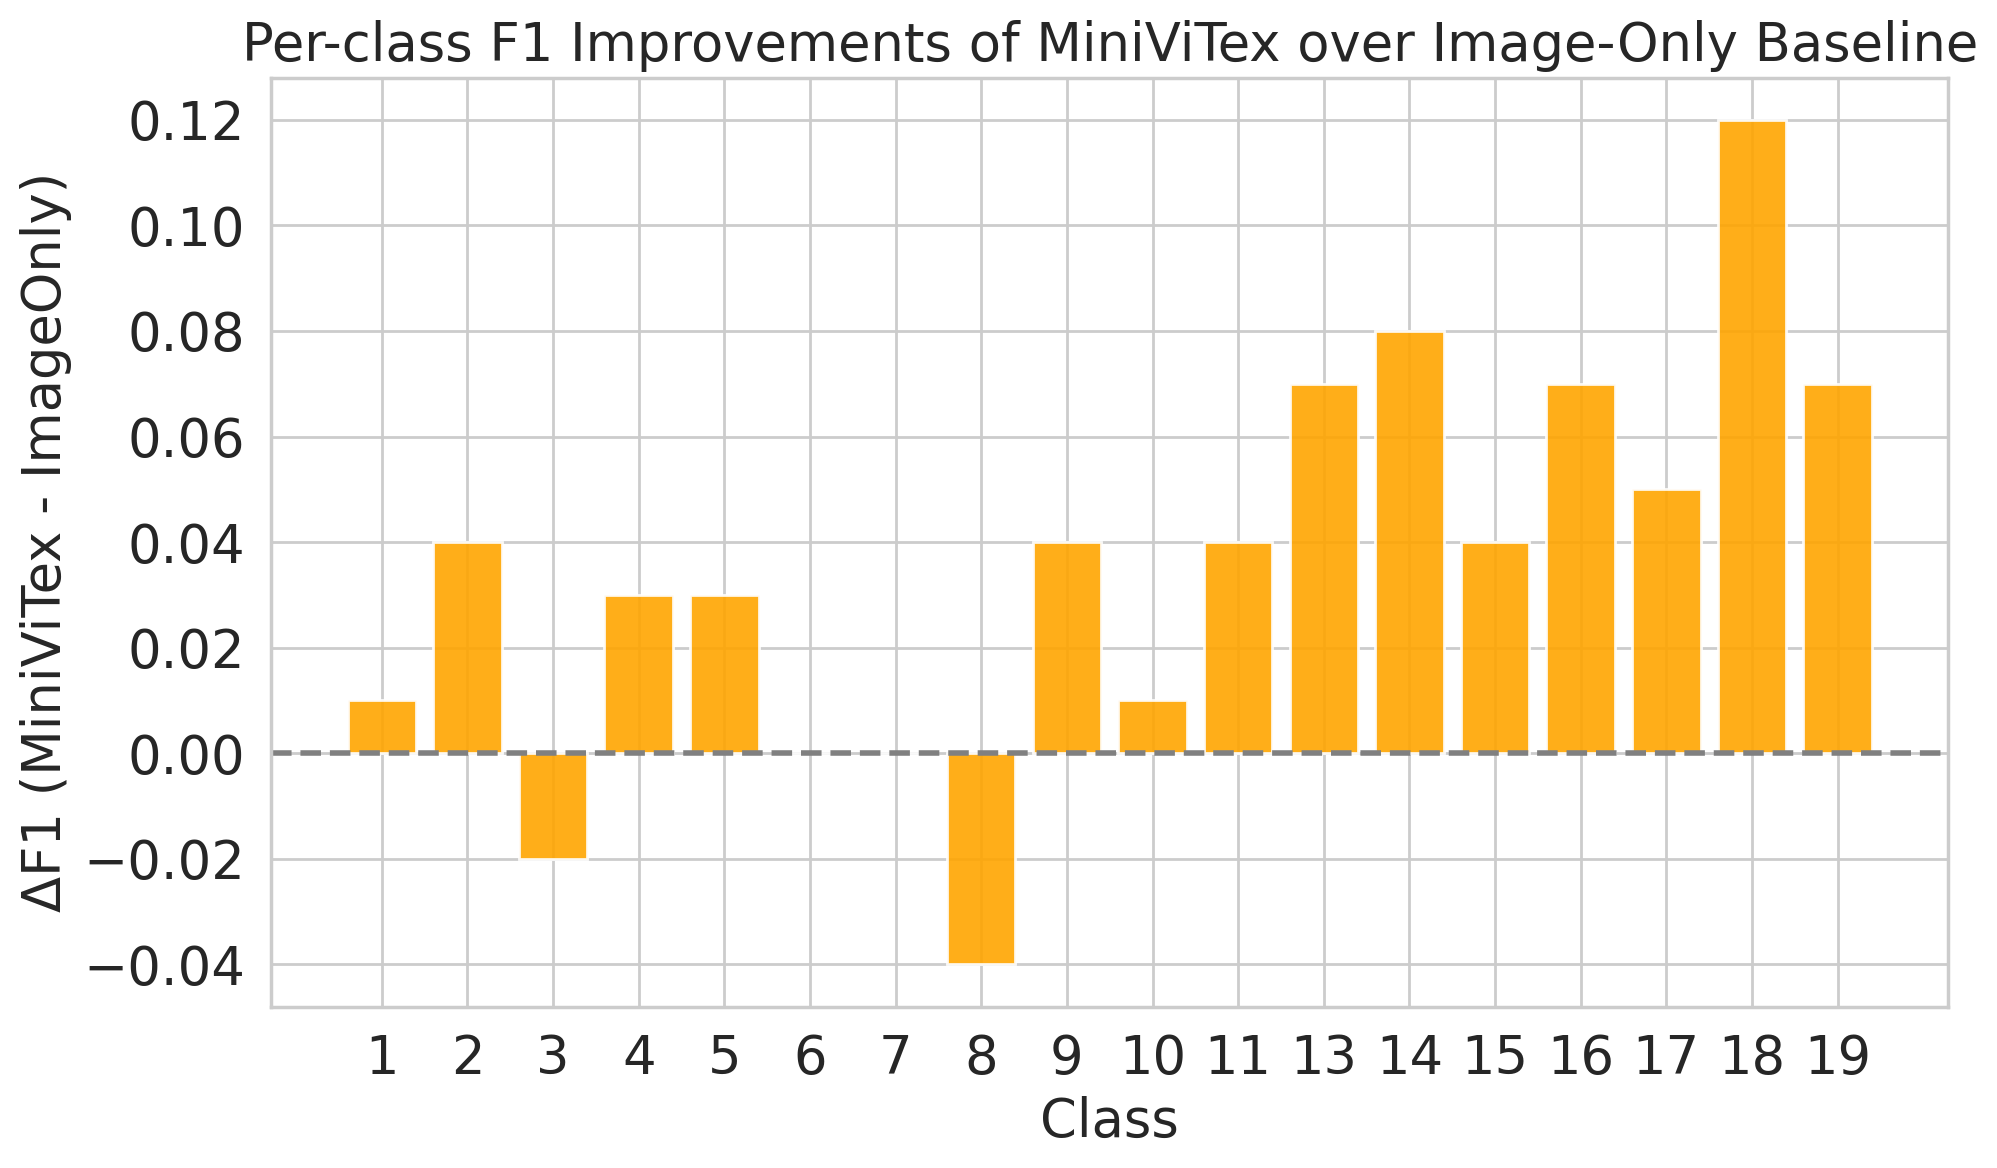

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Per‑class F1‑scores for the two models
data = {
    "Class": [1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19],
    "MiniViTex_F1": [0.95,0.65,0.63,0.87,0.98,0.82,0.92,0.59,0.81,0.71,0.75,0.68,0.82,0.60,0.77,0.92,0.87,0.94],
    "ImageOnly_F1": [0.94,0.61,0.65,0.84,0.95,0.82,0.92,0.63,0.77,0.70,0.71,0.61,0.74,0.56,0.70,0.87,0.75,0.87],
}

df = pd.DataFrame(data)
df["Delta_F1"] = (df["MiniViTex_F1"] - df["ImageOnly_F1"]).round(3)

# Plot the improvements
plt.figure(figsize=(10,6), dpi=200)
plt.bar(df["Class"].astype(str), df["Delta_F1"] , color='orange', alpha=0.9)
plt.axhline(0, linestyle='--', color='gray', linewidth=2)
plt.xlabel("Class", fontsize=19)
plt.ylabel("ΔF1 (MiniViTex - ImageOnly)", fontsize=19)
plt.title("Per-class F1 Improvements of MiniViTex over Image-Only Baseline", fontsize=19)
#font size of x-ticks
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.tight_layout()
plt.show()
